## Style Transfer

In [1]:
!unzip Q3.zip


Archive:  Q3.zip
 extracting: Q3/content/bear.jpg     
 extracting: Q3/content/building.jpg  
 extracting: Q3/content/cat.jpg      
 extracting: Q3/content/cat-on-table.jpg  
 extracting: Q3/content/cat-sleeping.jpg  
 extracting: Q3/content/cows.jpg     
 extracting: Q3/content/mountains.jpg  
 extracting: Q3/content/picnic.jpg   
 extracting: Q3/content/town.jpg     
 extracting: Q3/content/white-building.jpg  
 extracting: Q3/styles/bet-you.jpg   
 extracting: Q3/styles/Erin-Hanson-Monet's-Bridge.jpg  
 extracting: Q3/styles/head-of-paula-eyles.jpg  
 extracting: Q3/styles/horse-cart.jpg  
 extracting: Q3/styles/landscape-with-a-palace.jpg  
 extracting: Q3/styles/not-detected.jpg  
 extracting: Q3/styles/red-sea-passage.jpg  
 extracting: Q3/styles/the-couple.jpg  
 extracting: Q3/styles/the-exit-of-the-russian-ballet.jpg  
 extracting: Q3/styles/zebra.jpg     


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def pre_process(image_path, max_size=512):
    image = Image.open(image_path).convert("RGB")
    size = min(max_size, max(image.size))
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

def display(tensor):
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


In [5]:
def content_loss(content, target):
    return F.mse_loss(content, target)

In [6]:
def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    gram = torch.mm(features, features.t())
    return gram / (c * h * w)

In [7]:
def style_loss(style, target):
    return F.mse_loss(gram_matrix(style), gram_matrix(target))

In [8]:
def get_features(model, x, layers):
    features = {}
    i = 0

    for layer in model.children():
        x = layer(x)

        if isinstance(layer, nn.Conv2d):
            i += 1
            name = "conv_" + str(i)
            if name in layers:
                features[name] = x

    return features

In [9]:
def total_loss(target_img, content_features, style_grams, model, c_layers, s_layers, c_weight, s_weight):
    layers = c_layers + s_layers
    target_features = get_features(model, target_img, layers)

    c_loss = sum(content_loss(target_features[layer], content_features[layer]) for layer in content_layers)
    s_loss = sum(style_loss(target_features[layer], style_grams[layer]) for layer in style_layers)

    return content_weight * c_loss + style_weight * s_loss, c_loss, s_loss

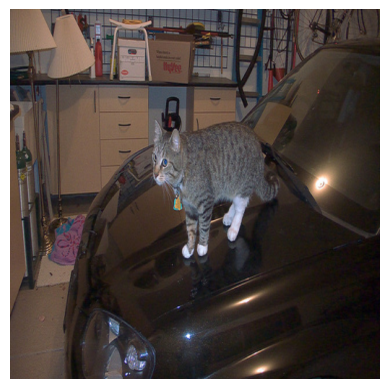

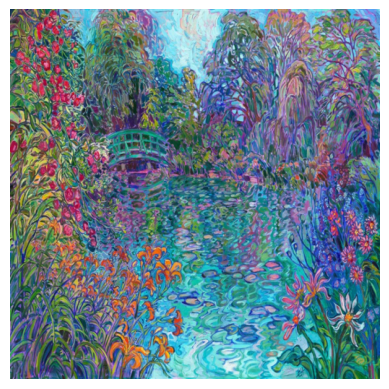

In [10]:
content_path = "/content/Q3/content/cat-on-table.jpg"
style_path = "/content/Q3/styles/Erin-Hanson-Monet's-Bridge.jpg"

content_img = pre_process(content_path)
style_img = pre_process(style_path)

display(content_img)
display(style_img)

content_layers = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

content_weight = 1
style_weight = 1e4
num_steps = 300

content_losses, style_losses, total_losses = [], [], []

In [11]:
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad = False



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 101MB/s]


In [12]:
def style_transfer(content_img, style_img, vgg, content_layers, style_layers, content_weight, style_weight, num_steps):
  content_img  = content_img.to(device)
  style_img = style_img.to(device)
  target_img = content_img.clone().requires_grad_(True).to(device)

  content_features = get_features(vgg, content_img, content_layers)
  style_features = get_features(vgg, style_img, style_layers)
  style_features_list = {layer: style_features[layer] for layer in style_layers}

  optimizer = optim.LBFGS([target_img])
  content_losses, style_losses, total_losses = [], [], []
  step = 0

  def closure():
    nonlocal step
    optimizer.zero_grad()
    loss, c_loss, s_loss = total_loss(target_img, content_features, style_features_list, vgg, content_layers, style_layers, content_weight, style_weight)
    loss.backward()

    content_losses.append(c_loss.item())
    style_losses.append(s_loss.item())
    total_losses.append(loss.item())

    step += 1

    if step % 50 == 0:
        print(f'Step {step}: Content Loss: {c_loss.item()}, Style Loss: {s_loss.item()}, Total Loss: {loss.item():.4f}')

    return loss

  for _ in range(num_steps):
      optimizer.step(closure)
      with torch.no_grad():
          target_img.clamp_(0, 1)

  return target_img, content_losses, style_losses, total_losses



Step 50: Content Loss: 0.06540301442146301, Style Loss: 2.089932604576461e-05, Total Loss: 0.2744
Step 100: Content Loss: 0.06522571295499802, Style Loss: 2.070433765766211e-05, Total Loss: 0.2723
Step 150: Content Loss: 0.06672131270170212, Style Loss: 2.0788836991414428e-05, Total Loss: 0.2746
Step 200: Content Loss: 0.06911462545394897, Style Loss: 2.061660234176088e-05, Total Loss: 0.2753
Step 250: Content Loss: 0.07504269480705261, Style Loss: 2.0818864868488163e-05, Total Loss: 0.2832
Step 300: Content Loss: 0.07369983196258545, Style Loss: 2.021974796662107e-05, Total Loss: 0.2759
Step 350: Content Loss: 0.08369506150484085, Style Loss: 2.0845915059908293e-05, Total Loss: 0.2922
Step 400: Content Loss: 0.07925422489643097, Style Loss: 2.0142693756497465e-05, Total Loss: 0.2807
Step 450: Content Loss: 0.0863269567489624, Style Loss: 2.041951120190788e-05, Total Loss: 0.2905
Step 500: Content Loss: 0.0753595381975174, Style Loss: 1.9908340618712828e-05, Total Loss: 0.2744
Step 550

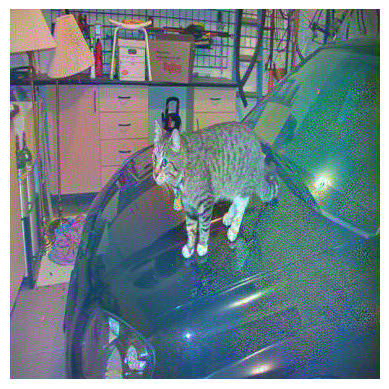

In [ ]:
target_img, content_losses, style_losses, total_losses = style_transfer(content_img, style_img, vgg, content_layers, style_layers, content_weight, style_weight, num_steps)
display(target_img)



In [13]:
config = {
    "Config1" : (1.0, 1e6),
    "Config2" : (5.0, 1e6),
    "Config3" : (0.1, 1e8),
    "Config4" : (5.0, 1e3),
    "Config5" : (0.01, 1e8)
}

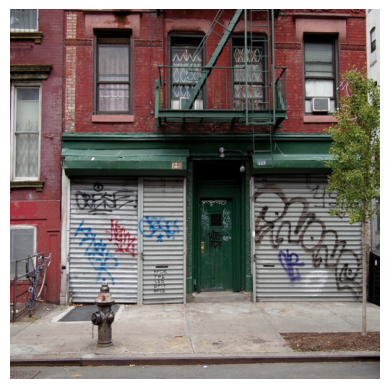

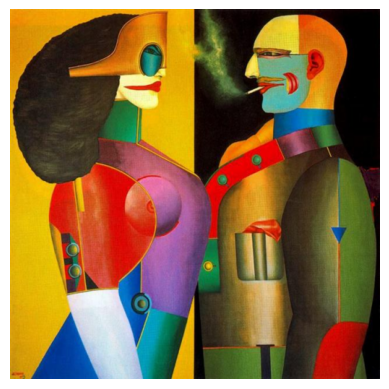

In [14]:
content_path = "/content/Q3/content/building.jpg"
style_path = "/content/Q3/styles/the-couple.jpg"

content_img = pre_process(content_path)
style_img = pre_process(style_path)

display(content_img)
display(style_img)

Step 50: Content Loss: 0.45659780502319336, Style Loss: 2.362689031087939e-07, Total Loss: 0.6929
Step 100: Content Loss: 0.4212728440761566, Style Loss: 1.232587010235875e-07, Total Loss: 0.5445
Step 150: Content Loss: 0.4159732460975647, Style Loss: 1.1722392656565717e-07, Total Loss: 0.5332
Step 200: Content Loss: 0.4122017025947571, Style Loss: 1.0970198616178095e-07, Total Loss: 0.5219
Step 250: Content Loss: 0.4130805432796478, Style Loss: 1.241001257312746e-07, Total Loss: 0.5372
Step 300: Content Loss: 0.4126967191696167, Style Loss: 1.0570960284894682e-07, Total Loss: 0.5184
Step 350: Content Loss: 0.4168799817562103, Style Loss: 1.2756012779391313e-07, Total Loss: 0.5444
Step 400: Content Loss: 0.4170433282852173, Style Loss: 1.0644825465533359e-07, Total Loss: 0.5235
Step 450: Content Loss: 0.41991397738456726, Style Loss: 1.3590182845746313e-07, Total Loss: 0.5558
Step 500: Content Loss: 0.42061567306518555, Style Loss: 1.0516980353258987e-07, Total Loss: 0.5258
Step 550: C

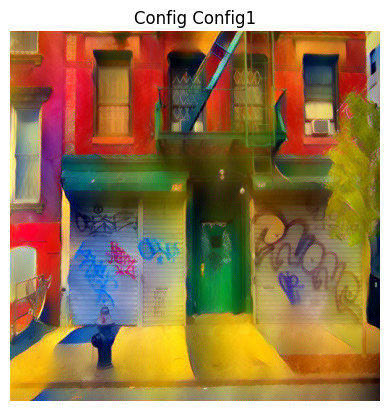

Step 50: Content Loss: 0.23539771139621735, Style Loss: 7.902881407062523e-07, Total Loss: 1.9673
Step 100: Content Loss: 0.23548749089241028, Style Loss: 5.824149411637336e-07, Total Loss: 1.7599
Step 150: Content Loss: 0.23420867323875427, Style Loss: 5.726772087655263e-07, Total Loss: 1.7437
Step 200: Content Loss: 0.23074999451637268, Style Loss: 5.577707042903057e-07, Total Loss: 1.7115
Step 250: Content Loss: 0.23035630583763123, Style Loss: 5.728451242248411e-07, Total Loss: 1.7246
Step 300: Content Loss: 0.2286355048418045, Style Loss: 5.581987920777465e-07, Total Loss: 1.7014
Step 350: Content Loss: 0.22963090240955353, Style Loss: 5.88431475989637e-07, Total Loss: 1.7366
Step 400: Content Loss: 0.228790283203125, Style Loss: 5.60914713787497e-07, Total Loss: 1.7049
Step 450: Content Loss: 0.2330247461795807, Style Loss: 6.378775196935749e-07, Total Loss: 1.8030
Step 500: Content Loss: 0.23205065727233887, Style Loss: 5.840020094183274e-07, Total Loss: 1.7443
Step 550: Content

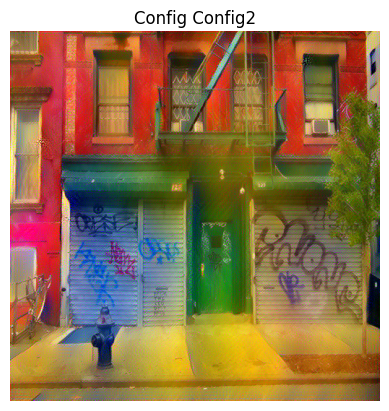

Step 50: Content Loss: 0.9363483786582947, Style Loss: 2.1298794194990478e-07, Total Loss: 21.3924
Step 100: Content Loss: 1.0099714994430542, Style Loss: 3.480897703411756e-08, Total Loss: 3.5819
Step 150: Content Loss: 1.0345444679260254, Style Loss: 2.0920877474850386e-08, Total Loss: 2.1955
Step 200: Content Loss: 1.0550086498260498, Style Loss: 1.3696919154426723e-08, Total Loss: 1.4752
Step 250: Content Loss: 1.077104091644287, Style Loss: 9.781229159955274e-09, Total Loss: 1.0858
Step 300: Content Loss: 1.092494010925293, Style Loss: 6.556018838921318e-09, Total Loss: 0.7649
Step 350: Content Loss: 1.1044299602508545, Style Loss: 5.028760963199375e-09, Total Loss: 0.6133
Step 400: Content Loss: 1.1090171337127686, Style Loss: 3.7286564946725775e-09, Total Loss: 0.4838
Step 450: Content Loss: 1.1133477687835693, Style Loss: 2.9715601090885002e-09, Total Loss: 0.4085
Step 500: Content Loss: 1.115828037261963, Style Loss: 2.3250414926678786e-09, Total Loss: 0.3441
Step 550: Content

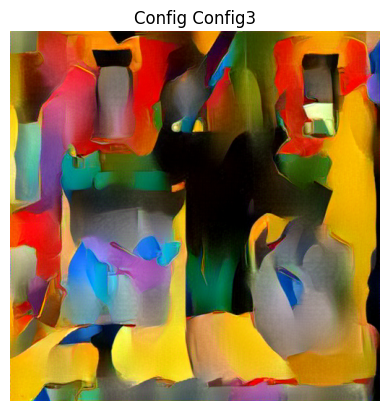

Step 50: Content Loss: 4.58630638604518e-05, Style Loss: 1.1732163329725154e-05, Total Loss: 0.0120
Step 100: Content Loss: 4.8858342779567465e-05, Style Loss: 1.1697859008563682e-05, Total Loss: 0.0119
Step 150: Content Loss: 5.019554009777494e-05, Style Loss: 1.168239123217063e-05, Total Loss: 0.0119
Step 200: Content Loss: 5.089047772344202e-05, Style Loss: 1.1672817890939768e-05, Total Loss: 0.0119
Step 250: Content Loss: 5.200567466090433e-05, Style Loss: 1.1664331395877525e-05, Total Loss: 0.0119
Step 300: Content Loss: 5.260532634565607e-05, Style Loss: 1.1657140930765308e-05, Total Loss: 0.0119
Step 350: Content Loss: 5.391899321693927e-05, Style Loss: 1.1650687156361528e-05, Total Loss: 0.0119
Step 400: Content Loss: 5.3683666919823736e-05, Style Loss: 1.164787681773305e-05, Total Loss: 0.0119
Step 450: Content Loss: 5.566190156969242e-05, Style Loss: 1.1644346159300767e-05, Total Loss: 0.0119
Step 500: Content Loss: 5.4977412219159305e-05, Style Loss: 1.1641424862318672e-05, 

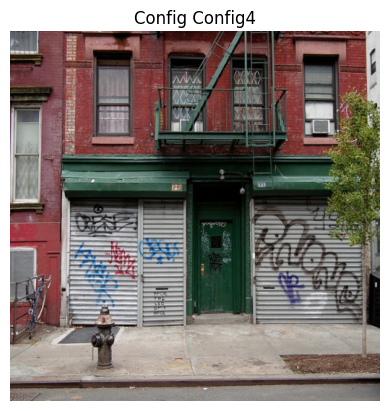

Step 50: Content Loss: 0.9174725413322449, Style Loss: 1.7590798506716965e-07, Total Loss: 17.6000
Step 100: Content Loss: 1.0087121725082397, Style Loss: 3.6067952180474094e-08, Total Loss: 3.6169
Step 150: Content Loss: 1.03826904296875, Style Loss: 2.091784523372553e-08, Total Loss: 2.1022
Step 200: Content Loss: 1.0639266967773438, Style Loss: 1.3588044467383043e-08, Total Loss: 1.3694
Step 250: Content Loss: 1.088573932647705, Style Loss: 9.777650689102302e-09, Total Loss: 0.9887
Step 300: Content Loss: 1.1064324378967285, Style Loss: 6.454937917510506e-09, Total Loss: 0.6566
Step 350: Content Loss: 1.1205997467041016, Style Loss: 4.829718402987737e-09, Total Loss: 0.4942
Step 400: Content Loss: 1.128175139427185, Style Loss: 3.582698582249577e-09, Total Loss: 0.3696
Step 450: Content Loss: 1.1345288753509521, Style Loss: 3.0019655650193044e-09, Total Loss: 0.3115
Step 500: Content Loss: 1.1393991708755493, Style Loss: 2.3735957643822303e-09, Total Loss: 0.2488
Step 550: Content L

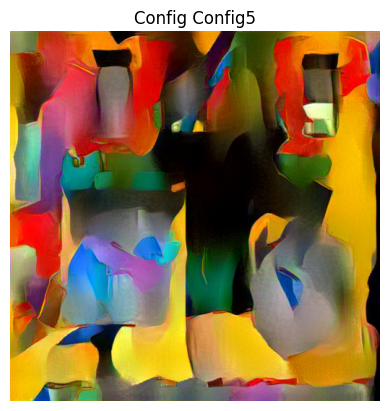

In [15]:
for config_name, (content_weight, style_weight) in config.items():
    target_img, content_losses, style_losses, total_losses = style_transfer(content_img, style_img, vgg, content_layers, style_layers, content_weight, style_weight, 100)
    plt.title(f"Config {config_name}")
    display(target_img)

#### Adam Optimiser

In [22]:
def style_transfer_with_Adam(content_img, style_img, vgg, content_layers, style_layers, content_weight, style_weight, num_steps):
    content_img  = content_img.to(device)
    style_img = style_img.to(device)
    target_img = content_img.clone().requires_grad_(True).to(device)

    content_features = get_features(vgg, content_img, content_layers)
    style_features = get_features(vgg, style_img, style_layers)
    style_features_list = {layer: style_features[layer] for layer in style_layers}

    optimizer = optim.Adam([target_img], lr=0.001)

    content_losses, style_losses, total_losses = [], [], []
    # start_time = time.time()

    for step in range(num_steps):
        optimizer.zero_grad()
        loss, c_loss, s_loss = total_loss(target_img, content_features, style_features_list, vgg, content_layers, style_layers, content_weight, style_weight)


        # loss, c_loss, s_loss = total_loss(target_img, content_features, style_grams, vgg, content_layers, style_layers, content_weight, style_weight)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            target_img.clamp_(0, 1)

        content_losses.append(c_loss.item())
        style_losses.append(s_loss.item())
        total_losses.append(loss.item())

        if step % 50 == 0:
            print(f'Step {step}: Content Loss: {c_loss.item()}, Style Loss: {s_loss.item():}, Total Loss: {loss.item():}')

    # time_taken = time.time() - start_time
    return target_img, content_losses, style_losses, total_losses



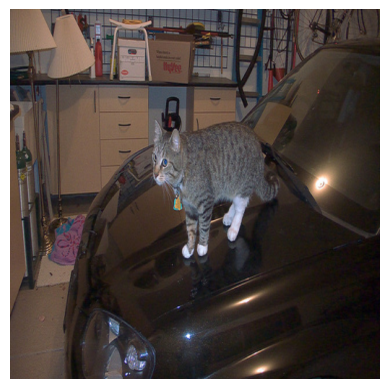

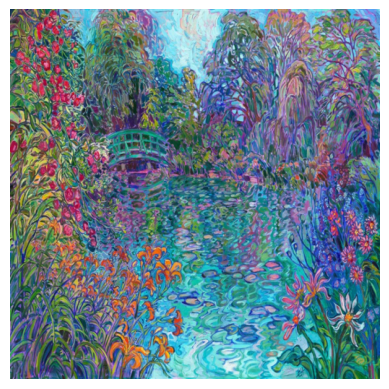

Step 0: Content Loss: 0.0, Style Loss: 3.358892718097195e-05, Total Loss: 0.3358892798423767
Step 50: Content Loss: 0.04434320330619812, Style Loss: 2.4403127099503763e-05, Total Loss: 0.28837448358535767
Step 100: Content Loss: 0.052279841154813766, Style Loss: 2.2911332052899525e-05, Total Loss: 0.2813931703567505
Step 150: Content Loss: 0.05598616600036621, Style Loss: 2.2211368559510447e-05, Total Loss: 0.27809983491897583
Step 200: Content Loss: 0.05816454440355301, Style Loss: 2.180176306865178e-05, Total Loss: 0.2761821746826172
Step 250: Content Loss: 0.05955497920513153, Style Loss: 2.153945570171345e-05, Total Loss: 0.2749495506286621
Step 300: Content Loss: 0.0605173259973526, Style Loss: 2.135733848263044e-05, Total Loss: 0.2740907073020935
Step 350: Content Loss: 0.061190925538539886, Style Loss: 2.1224821466603316e-05, Total Loss: 0.2734391391277313
Step 400: Content Loss: 0.06171531230211258, Style Loss: 2.111891080858186e-05, Total Loss: 0.2729044258594513
Step 450: Con

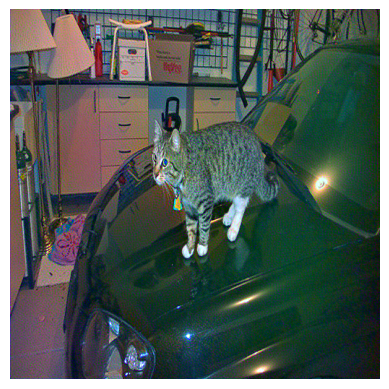

In [24]:
content_path = "/content/Q3/content/cat-on-table.jpg"
style_path = "/content/Q3/styles/Erin-Hanson-Monet's-Bridge.jpg"

content_img = pre_process(content_path)
style_img = pre_process(style_path)

display(content_img)
display(style_img)

content_layers = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

content_weight = 1
style_weight = 1e4
num_steps = 3000

content_losses_adam, style_losses_adam, total_losses_adam = [], [], []

result_adam, content_losses_adam, style_losses_adam, total_losses_adam = style_transfer_with_Adam(content_img, style_img, vgg, content_layers, style_layers, content_weight, style_weight, num_steps)

display(result_adam)

* For different configurations, transfer works differently.
* When the weight of the content is very high compared to the style, the output image is very similar to the content image, i,e. virtually no style transfer happens.
* When the weight of the style is very high compared to the content, the output image is very similar to the style image, i.e. virtually no content transfer happens.
* When the weights are balanced, the output image is a mix of the content and style images.
* Style loss is much less compared to content loss, so the style weight is much higher than the content weight.
* When the losses are of equal magnitde, the output image is a mix of the content and style images.


* Adam requires a lot more epochs to converge compared to L-BFGS. Even with a significantly higher number of epochs compared to L-BFGS, the output image is not as transfered as L-BFGS which used much fewer epochs.